# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

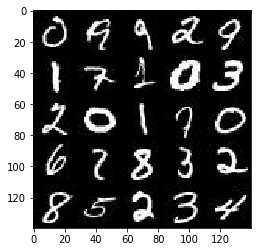

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

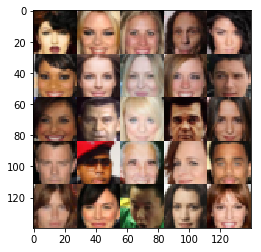

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_inputs = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return (real_inputs, z_inputs, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # The discriminator network is a regular convolutional network which takes in the real and fake images as input
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        leaky_relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(leaky_relu1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        leaky_relu2 = tf.maximum(alpha*batch_norm2, batch_norm2)

        x3 = tf.layers.conv2d(leaky_relu2, 256, 5, strides=1, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(x3, training=True)
        leaky_relu3 = tf.maximum(alpha*batch_norm3, batch_norm3)
        
        x4 = tf.layers.conv2d(leaky_relu3, 512, 5, strides=1, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(x4, training=True)
        leaky_relu4 = tf.maximum(alpha*batch_norm4, batch_norm4)

        # Now after the convolution layers we have to flatten the tensor and feed it into a fully-connected layer
        flattened_tensor = tf.reshape(leaky_relu4,(-1,7*7*512))
        logits = tf.layers.dense(flattened_tensor, 1)
        output = tf.sigmoid(logits) 
    return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True, alpha=0.25):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # The generator network works similar to a deconvolution network
    '''
    Reuse refers to when the variables of the generator will be used again. We want to first train the generator
    and then use it's trained variables to generate new images. So the is_train variable is used to monitor whether 
    the generator network is training or not, so that we can accordingly change reuse to the negative of training 
    mode to reuse variables when it is done training.
    '''
    with tf.variable_scope('generator', reuse= not is_train):
        ''' 
        For this network we will send the latent noise vector through a fully connected layer and then 
        reshape it into a deep convolutional stack layer
        '''
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha*x1, x1)
        
        # Now for the transpose convolutions..
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
    
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)

        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='SAME')
        output = tf.tanh(logits)
        return output
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    disc_model_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_model_fake, disc_logits_fake = discriminator(generator_model, reuse=True)
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, 
                                        labels=tf.ones_like(disc_model_fake)))
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, 
                                        labels=tf.ones_like(disc_model_real)))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, 
                                        labels=tf.zeros_like(disc_model_fake)))
    
    total_disc_loss = disc_loss_real + disc_loss_fake
    
    return (total_disc_loss, gen_loss)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    disc_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=discriminator_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=generator_vars)
    
    return (disc_optimizer, gen_optimizer)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr_ph, beta1)
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                batch_count += 1
                # Random noise for each batch
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real:batch_images, input_z:batch_z, lr_ph:learning_rate})
                _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, lr_ph:learning_rate})
                

                # Evaluating the results                
                if batch_count % 10 == 0:
                    train_loss_d = disc_loss.eval({input_real: batch_images, input_z:batch_z, lr_ph: learning_rate})
                    train_loss_g = gen_loss.eval({input_z: batch_z, lr_ph:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if batch_count % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.2261... Generator Loss: 31.7923
Epoch 1/2... Discriminator Loss: 0.0067... Generator Loss: 9.9656
Epoch 1/2... Discriminator Loss: 0.1423... Generator Loss: 22.0924
Epoch 1/2... Discriminator Loss: 2.1028... Generator Loss: 3.8481
Epoch 1/2... Discriminator Loss: 11.6280... Generator Loss: 22.5299
Epoch 1/2... Discriminator Loss: 0.2503... Generator Loss: 5.6771
Epoch 1/2... Discriminator Loss: 0.0970... Generator Loss: 5.3324
Epoch 1/2... Discriminator Loss: 3.5948... Generator Loss: 0.2476
Epoch 1/2... Discriminator Loss: 0.2780... Generator Loss: 2.8706
Epoch 1/2... Discriminator Loss: 2.5737... Generator Loss: 0.1698


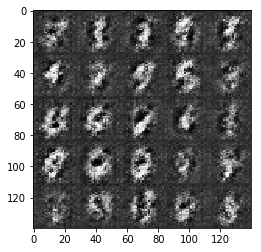

Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.7867
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 1.4543
Epoch 1/2... Discriminator Loss: 0.4956... Generator Loss: 1.6577
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.1019
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.4437
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 1.5426
Epoch 1/2... Discriminator Loss: 0.3298... Generator Loss: 2.0103
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 1.6523


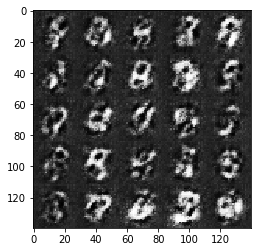

Epoch 1/2... Discriminator Loss: 2.7211... Generator Loss: 8.0201
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 2.1625... Generator Loss: 0.2128
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 2.4943
Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 1.7299
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.4893
Epoch 2/2... Discriminator Loss: 0.2161... Generator Loss: 2.3383
Epoch 2/2... Discriminator Loss: 0.1781... Generator Loss: 2.3872
Epoch 2/2... Discriminator Loss: 2.4545... Generator Loss: 9.3532
Epoch 2/2... Discriminator Loss: 0.2804... Generator Loss: 2.2322


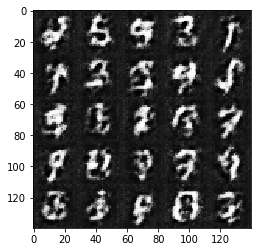

Epoch 2/2... Discriminator Loss: 0.5224... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 0.2713... Generator Loss: 1.8649
Epoch 2/2... Discriminator Loss: 0.2234... Generator Loss: 2.1587
Epoch 2/2... Discriminator Loss: 2.8136... Generator Loss: 0.1279
Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.1487
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 1.6206
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 1.2719
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 1.4810


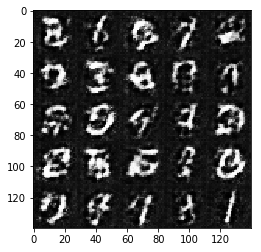

Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 1.0485
Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 1.4264
Epoch 2/2... Discriminator Loss: 3.4249... Generator Loss: 0.1026
Epoch 2/2... Discriminator Loss: 1.9209... Generator Loss: 0.2720
Epoch 2/2... Discriminator Loss: 0.2876... Generator Loss: 2.2165
Epoch 2/2... Discriminator Loss: 0.4345... Generator Loss: 1.4415


In [25]:
batch_size = 256
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.9111
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 9.2129
Epoch 1/1... Discriminator Loss: 4.8253... Generator Loss: 0.0763
Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 18.5670
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 4.6247
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 2.7033... Generator Loss: 6.4448
Epoch 1/1... Discriminator Loss: 2.2704... Generator Loss: 0.2077
Epoch 1/1... Discriminator Loss: 2.1971... Generator Loss: 0.1979


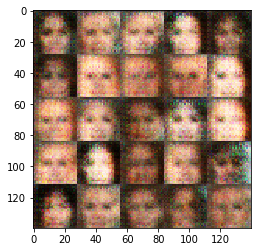

Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 2.3859
Epoch 1/1... Discriminator Loss: 1.7183... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 2.0638... Generator Loss: 3.8703
Epoch 1/1... Discriminator Loss: 1.9779... Generator Loss: 0.2595
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 1.2534


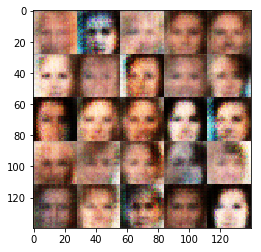

Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.3761


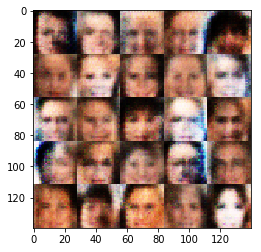

Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 2.4042... Generator Loss: 4.2395
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.4816


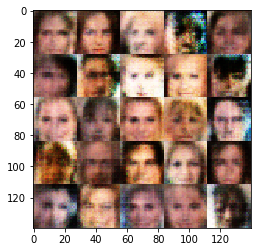

Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.6999... Generator Loss: 2.7752
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 2.8491... Generator Loss: 0.1035
Epoch 1/1... Discriminator Loss: 2.1535... Generator Loss: 0.2484
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.4926


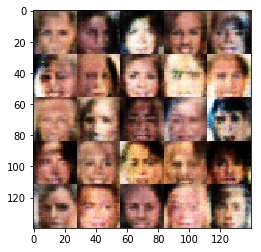

Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.8939
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 1.2261


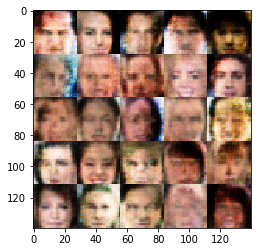

Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.3743


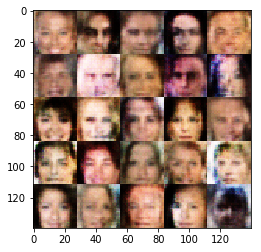

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.5439
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 2.0792... Generator Loss: 0.1988


In [26]:
batch_size = 256
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.